# SimpleElastix tutorial
[SimpleElastix](https://simpleelastix.github.io/) is a robust tool for image registration which works really well out-of-the-box. It works on both Windows and Linux.

### Installation
To use it in python, install [SimpleITK-SimpleElastix](https://pypi.org/project/SimpleITK-SimpleElastix/). It is the normal SimpleITK, but built with `SimpleITK_USE_ELASTIX` flag. Note that installing this will not automatically uninstall normal SimpleITK, this is usually fine but if you get exceptions when importing SimpleElastix related functionality, try uninstalling SimpleITK before installing SimpleITK-SimpleElastix build.

### Usage
If you want to use SimpleElastix without mrid, the python API documentation is available here https://simpleelastix.readthedocs.org/. This also provides a good introduction to image registration in general.

mrid provides API for SimpleElastix in `mrid.simple_elastix` subpackage, as well as `study.register_SE`, `study.register_each_SE` methods on `mrid.Study`. Let's review the ``mrid.simple_elastix`` functionality first.

#### Data
For this example we download some MRIs from https://zenodo.org/records/7213153 in DICOM format.

Colin Vanden Bulcke. (2022). Open-Access DICOM MRI session (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7213153

In [1]:
# uncoment if running on Colab or Kaggle
# !pip install mrid
# !pip install SimpleITK-SimpleElastix

# note that since the download is large, this script may fail or download corrupted ZIP. 
# In this case you can try downloading it manually from your browser or use any other MRIs you have.

import os, shutil, requests
from pathlib import Path

if "BMAT_MRI_session" not in os.listdir("data"):

    # download
    if "BMAT_MRI_session.zip" not in os.listdir("data"):
        response = requests.get("https://zenodo.org/records/7213153/files/BMAT_MRI_session.zip?download=1", stream=True)
        response.raise_for_status()
        with open("data/BMAT_MRI_session.zip", 'wb') as file:
            shutil.copyfileobj(response.raw, file) # type:ignore

    # unpack
    shutil.unpack_archive("data/BMAT_MRI_session.zip", "data")

ROOT = Path("data/BMAT_MRI_session/export/home1/sdc_image_pool/images/p883/e1007")
os.listdir(ROOT)

['s16342',
 's16335',
 's16343',
 's16329',
 's16341',
 's16340',
 's16336',
 's16337',
 's16328',
 's16330']

#### Registering one image to another

Registering one image to another can be performed via `mrid.simple_elastix.register` function. Let's register T1 to the commonly used SRI24 template.

The scans you pass can be path to a .nii.gz file, DICOM directory, sitk.Image, numpy array or torch tensor, and all functions return `sitk.Image`.

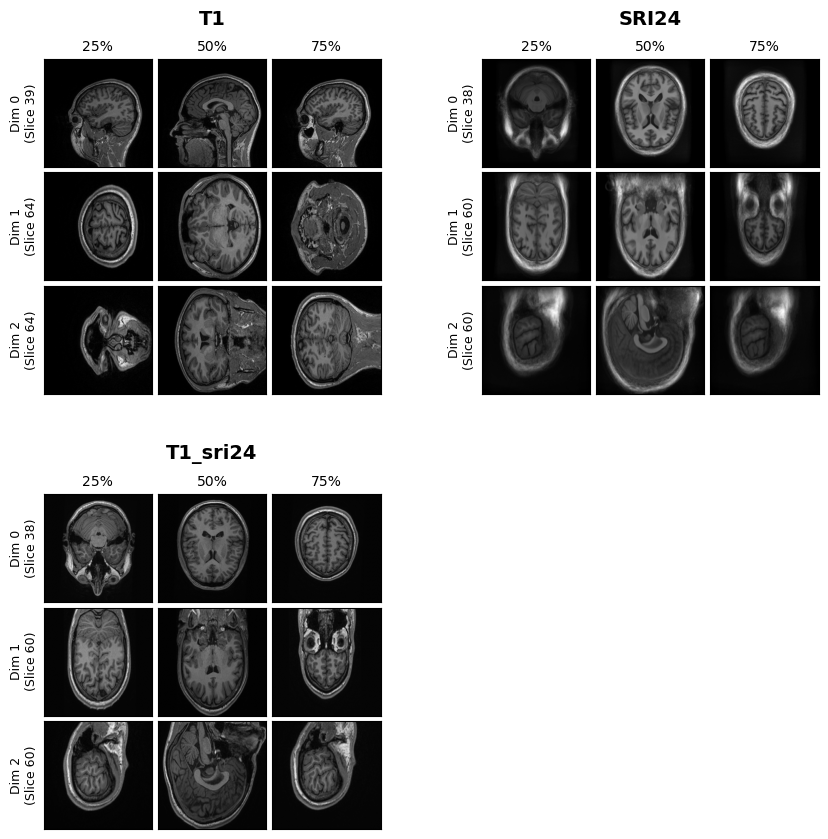

In [2]:
import mrid
import numpy as np

T1 = ROOT / "s16329"
template = mrid.get_sri24(type="T1") # this returns path to nii.gz file of SRI24 template.

T1_sri24 = mrid.simple_elastix.register(T1, to=template) # sitk.Image

mrid.utils.plot_study({"T1": T1, "SRI24": template, "T1_sri24": T1_sri24})

#### Undoing registration

Another way to perform registration is via `mrid.simple_elastix.SimpleElastix` class. This can also be used to transform multiple modalities, and undo the transform (i.e. performing inverse transform).

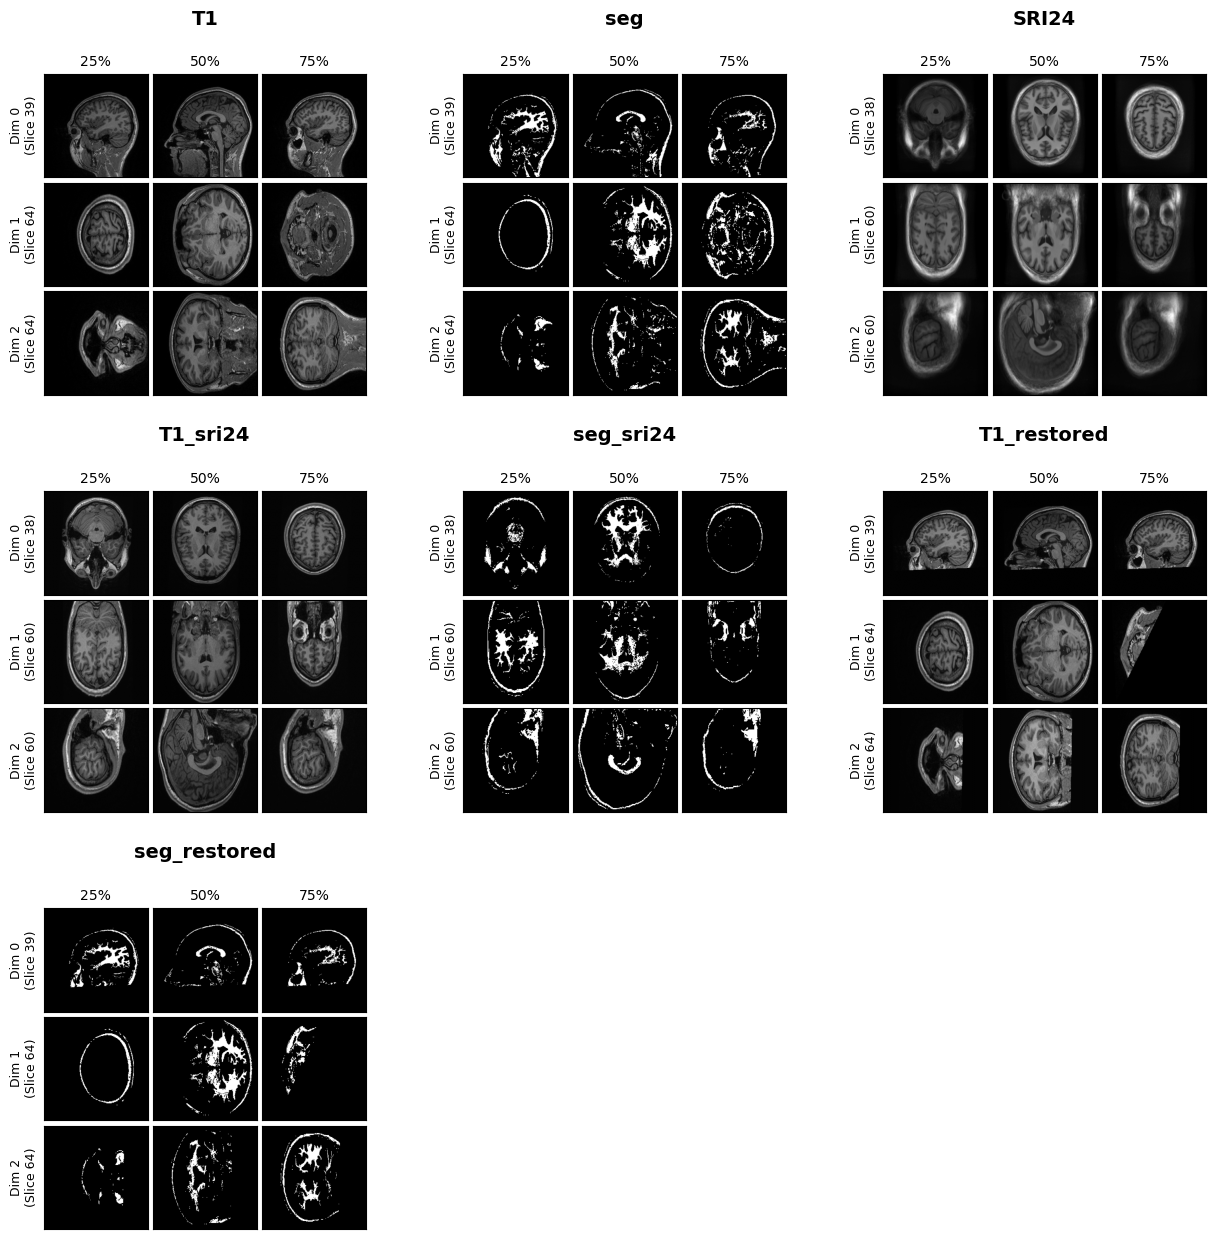

In [7]:
reg = mrid.simple_elastix.SimpleElastix()

# first we need to find a transform that aligns moving image with fixed image
# to do that, call `reg.find_transform(moving, fixed)`
# that method also returns `moving` registered to `fixed`
T1_sri24 = reg.find_transform(T1, to=template)

# now we can reuse the transform and apply it to other images
# that are aligned with T1_sri24
# for segmentation also set `use_nearest_interpolation=True` to avoid softening the edges.
seg = (mrid.tonumpy(T1) > 1000).astype(np.uint8)
seg_sri24 = reg.apply_transform(seg, use_nearest_interpolation=True)

# to apply inverse transform, use `reg.apply_inverse_transform`
T1_restored = reg.apply_inverse_transform(T1_sri24)
seg_restored = reg.apply_inverse_transform(seg_sri24, use_nearest_interpolation=True)

mrid.utils.plot_study(
    {
        "T1": T1,
        "seg": seg,
        "SRI24": template,
        "T1_sri24": T1_sri24,
        "seg_sri24": seg_sri24,
        "T1_restored": T1_restored,
        "seg_restored": seg_restored,
    }
)

#### Registering multiple aligned images
If you have multiple images that are already aligned to each other, you can use `mrid.simple_elastix.register_D`.

This registers one specified modality to fixed image, and then reuses the transform to register other modalities. This is the same as reusing `apply_transform` in the `mrid.simple_elastix.SimpleElastix` example above.

data_sri24 = {'T1': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f1e9747d200> >, 'seg': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f1d5fbaba80> >}


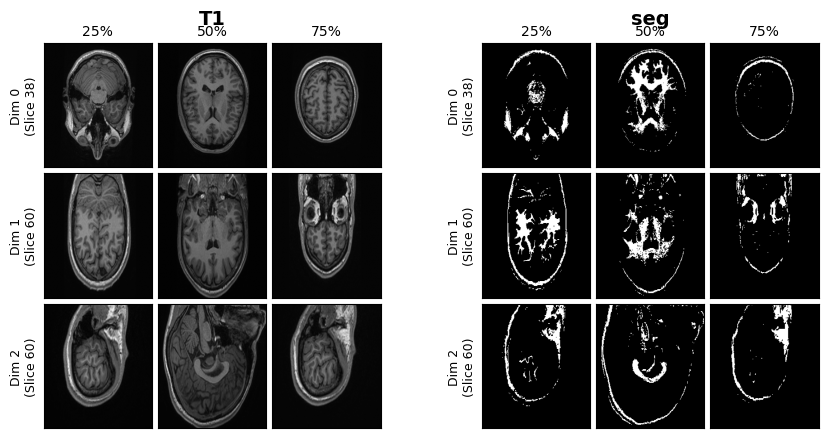

In [4]:
data = {"T1": ROOT / "s16329", "seg": seg}

# register "T1" to template and use transform to register "seg"
data_sri24 = mrid.simple_elastix.register_D(data, key="T1", to=template)
print(f'{data_sri24 = }')

mrid.utils.plot_study(data_sri24)

#### Registering multiple modalities that are not aligned

If you have multiple modalities that are not aligned, a good way to align them is to register them to one of them, e.g to T1. 

In mrid you can do that via `mrid.simple_elastix.register_each`. It also accepts an optional `to` argument, which, if, provided, registers `data[key]` to `to` beforehand.

data_aligned = {'T1': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f1d618eaa60> >, 'FLAIR': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7f1d5f5753b0> >}


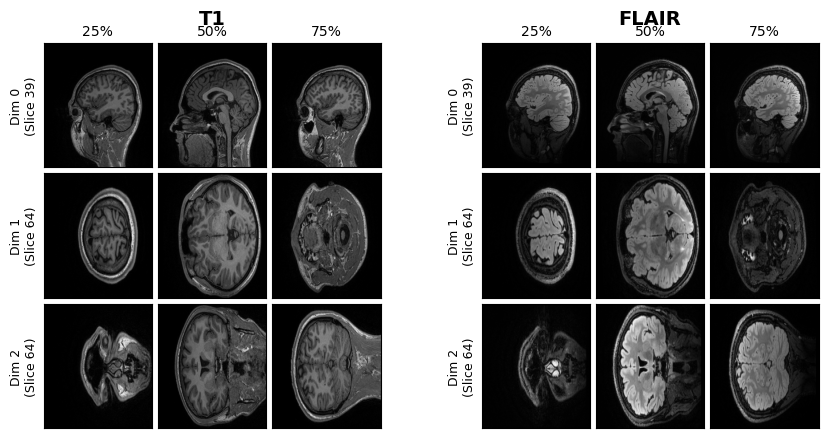

In [5]:
data = {
    "T1": ROOT / "s16329",
    "FLAIR": ROOT/"s16340",
}

# register all other modalities to "T1"
data_aligned = mrid.simple_elastix.register_each(data, key="T1")
print(f'{data_aligned = }')

mrid.utils.plot_study(data_aligned)

### Study interace

`study.register_SE` and `study.register_each_SE` are the same as `mrid.simple_elastix.register_D` and `mrid.simple_elastix.register_each`.

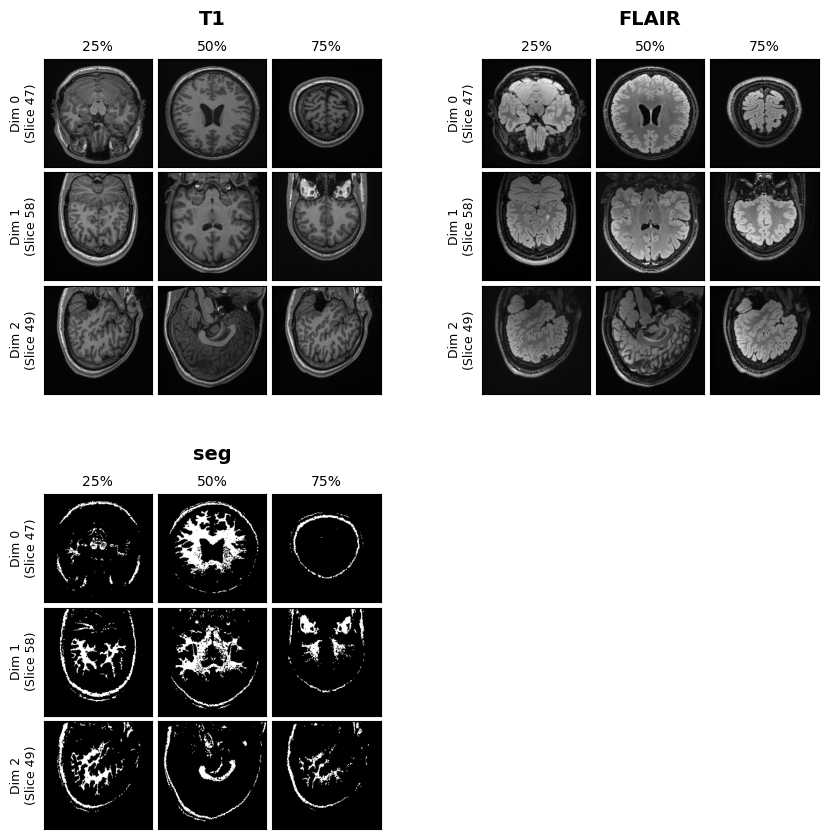

In [11]:
study = mrid.Study(T1 = ROOT / "s16329", FLAIR = ROOT / "s16340")

# register "T1" to SRI24 and then register all other modalities to "T1"
study_sri24 = study.register_each_SE(key="T1", to=mrid.get_sri24("T1"))

# add segmentation that is in SRI24 and copy spatial information from T1 (since its a numpy array)
study_sri24 = study_sri24.add("seg", seg_sri24, reference_key="T1")

# now that the study is aligned, we can use `register` method. Let's suppose we now need study in MNI152
study_mni152 = study_sri24.register_SE("T1", to=mrid.get_mni152("2009a T1w asymmetric"))
study_mni152.plot()